<a href="https://colab.research.google.com/github/dottorm/styleganv2/blob/main/tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\Drive/tesi

Mounted at /content/drive
/content/drive/MyDrive/tesi


In [ ]:
#!git clone https://github.com/AmarSaini/Epoching_StyleGan2_Setup.git

Cloning into 'Epoching_StyleGan2_Setup'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 106 (delta 10), reused 93 (delta 6), pack-reused 0
Receiving objects: 100% (106/106), 3.81 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
#import shutil
#from pathlib import Path

#repo_root = Path('Epoching_StyleGan2_Setup/')

# Pull contents out of the repo, into our current directory.
#for content in repo_root.iterdir():
#    shutil.move(str(content), '.')

In [2]:
!pip install requests
!pip install Pillow
!pip install tqdm
!pip install dlib

In [3]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [4]:
import os
import sys
sys.path.append('stylegan2/')
from stylegan2 import pretrained_networks
from stylegan2 import dnnlib
from stylegan2.dnnlib import tflib
from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm
model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
results_size = 512

In [5]:
# Code to load the StyleGAN2 Model
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

# Generate images given a random seed (Integer)
def generate_image_random(rand_seed):
    rnd = np.random.RandomState(rand_seed)
    z = rnd.randn(1, *Gs.input_shape[1:])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
    images = Gs.run(z, None, **Gs_kwargs)
    return images, z

# Generate images given a latent code ( vector of size [1, 512] )
def generate_image_from_z(z):
    images = Gs.run(z, None, **Gs_kwargs)
    return images

def generate_image_from_projected_latents(latent_vector):
    images = Gs.components.synthesis.run(latent_vector, **Gs_kwargs)
    return images

In [6]:
Gs, noise_vars, Gs_kwargs = load_model()

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [7]:
#Pulisco le directory per una nuova generazione
import shutil
file_path = 'imgs/test1.jpg'
orig_img_path = Path('imgs')
aligned_imgs_path = Path('aligned_imgs')
results_path = Path('results')

if os.path.exists(file_path):
  os.remove(file_path)

if orig_img_path.exists():
  orig_img_path.rmdir()
  orig_img_path.mkdir()

if aligned_imgs_path.exists():
  shutil.rmtree(aligned_imgs_path)
  aligned_imgs_path.mkdir()

if results_path.exists():
  shutil.rmtree(results_path)
  results_path.mkdir()

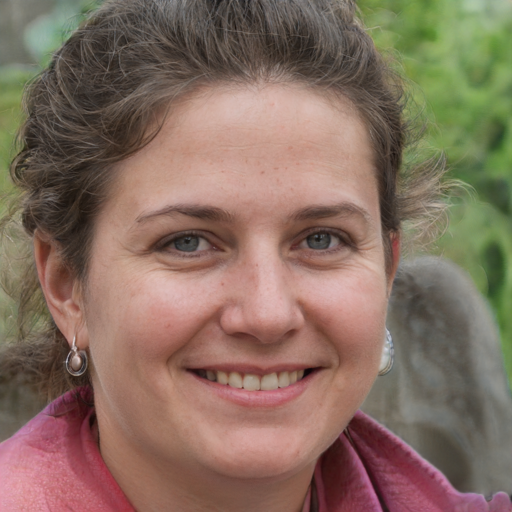

In [8]:
import random
images, latent_code1 = generate_image_random(random.randrange(0, 3999999999))
result = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code1.shape

result.save(file_path)
result

In [9]:
from align_face import align_face

# Align all of our images using a landmark detection model!
all_imgs = list(orig_img_path.iterdir())
for img in all_imgs:
    align_face(str(img)).save(aligned_imgs_path/('aligned_'+img.name))

Number of faces detected: 1
Detection 0: Left: 98 Top: 134 Right: 419 Bottom: 455
Part 0: (79, 256), Part 1: (84, 298) ...


In [10]:
!python -W ignore stylegan2/dataset_tool.py create_from_images datasets_stylegan2/custom_imgs aligned_imgs/

Loading images from "aligned_imgs/"
Creating dataset "datasets_stylegan2/custom_imgs"
Added 1 images.


In [11]:
tot_aligned_imgs = 1
!python -W ignore stylegan2/epoching_custom_run_projector.py project-real-images --network=$model_path \
  --dataset=custom_imgs --data-dir=datasets_stylegan2 --num-images=$tot_aligned_imgs --num-snapshots 500

Local submit - run_dir: results/00000-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from "custom_imgs"...
tcmalloc: large alloc 4294967296 bytes == 0x560e986e4000 @  0x7efef7442001 0x7efef4fc054f 0x7efef5010b58 0x7efef5014b17 0x7efef50b3203 0x560e6179e544 0x560e6179e240 0x560e61812627 0x560e6180cced 0x560e617a048c 0x560e617e1159 0x560e617de0a4 0x560e617a0698 0x560e6180efe4 0x560e6180c9ee 0x560e6179fbda 0x560e6180e737 0x560e6180c9ee 0x560e616dee2b 0x560e6180efe4 0x560e6179fafa 0x560e6180d915 0x560e6179fafa 0x560e6180dc0d 0x560e6180c9ee 0x560e616dee2b 0x560e6180efe4 0x560e6179fafa 0x560e6180d915 0x560e6180c9ee 0x560e6180c6f3
tcmalloc: large alloc 4294967296 bytes == 0x560f986e4000 @  0x7efef74401e7 0x

In [12]:
def get_final_latents():
    all_results = list(Path('results').iterdir())
    all_results.sort()
    
    last_result = all_results[-1]

    latent_files = [x for x in last_result.iterdir() if 'final_latent_code' in x.name]
    latent_files.sort()
    
    all_final_latents = []
    
    for file in latent_files:
        with open(file, mode='rb') as latent_pickle:
            all_final_latents.append(pickle.load(latent_pickle))
    
    return all_final_latents

latent_codes = get_final_latents()
len(latent_codes), latent_codes[0].shape


(1, (1, 18, 512))

In [13]:
def get_control_latent_vectors(path):
    files = [x for x in Path(path).iterdir() if str(x).endswith('.npy')]
    latent_vectors = {f.name[:-4]:np.load(f) for f in files}
    return latent_vectors

latent_controls = get_control_latent_vectors('stylegan2directions/')
len(latent_controls), latent_controls.keys(), latent_controls['age'].shape

(16,
 dict_keys(['age', 'eye_distance', 'eye_eyebrow_distance', 'eye_ratio', 'eyes_open', 'gender', 'lip_ratio', 'mouth_open', 'mouth_ratio', 'nose_mouth_distance', 'nose_ratio', 'nose_tip', 'pitch', 'roll', 'smile', 'yaw']),
 (18, 512))

In [46]:
def apply_latent_controls(self):
    
    image_outputs = controller.children[0]
    feature_sliders = controller.children[1]
    
    slider_hboxes = feature_sliders.children
    #latent_movements = [(x.children[1].value, x.children[0].value) for x in slider_hboxes]

    latent_movements = []
    for x in slider_hboxes:
      if x.description == 'lip_ratio':
        if x.value == 'slim':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'big':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'yaw':
        if x.value == 'left':
          latent_movements.append(tuple((x.description, 15.0)))
        elif x.value == 'right':
          latent_movements.append(tuple((x.description, -15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'gender':
        if x.value == 'male':
          latent_movements.append(tuple((x.description, 5.0)))
        elif x.value == 'female':
          latent_movements.append(tuple((x.description, -5.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'smile':
        if x.value == 'yes':
          latent_movements.append(tuple((x.description, 5.0)))
        elif x.value == 'no':
          latent_movements.append(tuple((x.description, -5.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'age':
        if x.value == 'young':
          latent_movements.append(tuple((x.description, -5.0)))
        elif x.value == 'mid age':
          latent_movements.append(tuple((x.description, 1.20)))
        elif x.value == 'old':
          latent_movements.append(tuple((x.description, 5.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'eyes_open':
        if x.value == 'small':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'big':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'roll':
        if x.value == 'black':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'white':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'nose_ratio':
        if x.value == 'big':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'small':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'nose_mouth_distance':
        if x.value == 'big':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'small':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'pitch':
        if x.value == 'back':
          latent_movements.append(tuple((x.description, 15.0)))
        elif x.value == 'front':
          latent_movements.append(tuple((x.description, -15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'eye_distance':
        if x.value == 'big':
          latent_movements.append(tuple((x.description, -15.0)))
        elif x.value == 'small':
          latent_movements.append(tuple((x.description, 15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      if x.description == 'eye_eyebrow_distance':
        if x.value == 'big':
          latent_movements.append(tuple((x.description, 15.0)))
        elif x.value == 'small':
          latent_movements.append(tuple((x.description, -15.0)))
        else:
          latent_movements.append(tuple((x.description, 0.0)))
      
    modified_latent_code = np.array(latent_code_to_use)
    for feature, amount_to_move in latent_movements:
        modified_latent_code += latent_controls[feature]*amount_to_move

    images = generate_image_from_projected_latents(modified_latent_code)
    latent_img = Image.fromarray(images[0]).resize((512, 512))
    
    latent_img_output = image_outputs.children[1]
    with latent_img_output:
        latent_img_output.clear_output()
        display(latent_img)

def create_interactive_latent_controller():
    orig_img_output = widgets.Output()

    with orig_img_output:
        orig_img_output.clear_output()
        display(result)

    latent_img_output = widgets.Output()

    with latent_img_output:
        latent_img_output.clear_output()
        display(result)

    image_outputs = widgets.VBox([orig_img_output, latent_img_output])

    #collapse-hide
    generate_button = widgets.Button(description='Generate', layout=widgets.Layout(width='75%', height='10%'))
    generate_button.on_click(apply_latent_controls)

    reset_button = widgets.Button(description='Reset Latent Controls', layout=widgets.Layout(width='75%', height='10%'))
    #reset_button.on_click(reset_latent_controls)

    feature_sliders = []
    age_buttons = widgets.ToggleButtons(
    options=['defaul','young', 'mid age', 'old'],
    description='age',)
    smile_buttons = widgets.ToggleButtons(
    options=['default', 'no', 'yes'],
    description='smile',)
    gender_buttons = widgets.ToggleButtons(
    options=['default', 'male', 'female'],
    description='gender',)
    yaw_buttons = widgets.ToggleButtons(
    options=['default', 'right', 'left'],
    description='yaw',)
    lip_ratio_buttons = widgets.ToggleButtons(
    options=['default', 'slim', 'big'],
    description='lip_ratio',)
    eyes_open_buttons = widgets.ToggleButtons(
    options=['default', 'small', 'big'],
    description='eyes_open',)
    roll_buttons = widgets.ToggleButtons(
    options=['default', 'white', 'black'],
    description='roll',)
    nose_ratio_buttons = widgets.ToggleButtons(
    options=['default', 'big', 'small'],
    description='nose_ratio',)
    nose_mouth_buttons = widgets.ToggleButtons(
    options=['default', 'big', 'small'],
    description='nose_mouth_distance',)
    pitch_buttons = widgets.ToggleButtons(
    options=['default', 'back', 'front'],
    description='pitch',)
    eye_distance_buttons = widgets.ToggleButtons(
    options=['default', 'big', 'small'],
    description='eye_distance',)
    eye_eyebrow_buttons = widgets.ToggleButtons(
    options=['default', 'big', 'small'],
    description='eye_eyebrow_distance',)
    #feature_sliders.appe'd(widgets.HBox([label, age_buttons]))
    feature_sliders.append(age_buttons)
    feature_sliders.append(smile_buttons)
    feature_sliders.append(gender_buttons)
    feature_sliders.append(yaw_buttons)
    feature_sliders.append(lip_ratio_buttons)
    feature_sliders.append(eyes_open_buttons)
    feature_sliders.append(roll_buttons)
    feature_sliders.append(nose_ratio_buttons)
    feature_sliders.append(nose_mouth_buttons)
    feature_sliders.append(pitch_buttons)
    feature_sliders.append(eye_distance_buttons)
    feature_sliders.append(eye_eyebrow_buttons)
    feature_sliders.append(generate_button)
    feature_sliders = widgets.VBox(feature_sliders)

    return widgets.HBox([image_outputs, feature_sliders])

In [47]:
latent_code_to_use = latent_codes[0]
image_to_use = result

controller = create_interactive_latent_controller()
controller